In [22]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler

spark = SparkSession.builder.master("local[*]").appName("appname").getOrCreate()

In [23]:
# Load data
df_raw = spark.read.option("delimiter", "\t").option("header", True).csv("data/data-final.csv")

# Prepare data
df_rates = df_raw\
    .withColumn("EXT", (col("EXT1") + (6-col("EXT2")) + col("EXT3") + (6-col("EXT4")) + col("EXT5") +
                        (6-col("EXT6")) + col("EXT7") + (6-col("EXT8")) + col("EXT9") + (6-col("EXT10")))/10)\
    .withColumn("EST", ((6-col("EST1")) + col("EST2") + (6-col("EST3")) + col("EST4") + (6-col("EST5")) +
                        (6-col("EST6")) + (6-col("EST7")) + (6-col("EST8")) + (6-col("EST9")) + (6-col("EST10")))/10)\
    .withColumn("AGR", ((6-col("AGR1")) + col("AGR2") + (6-col("AGR3")) + col("AGR4") + (6-col("AGR5")) +
                        col("AGR6") + (6-col("AGR7")) + col("AGR8") + col("AGR9") + col("AGR10"))/10)\
    .withColumn("CSN", (col("CSN1") + (6-col("CSN2")) + col("CSN3") + (6-col("CSN4")) + col("CSN5") +
                        (6-col("CSN6")) + col("CSN7") + (6-col("CSN8")) + col("CSN9") + col("CSN10"))/10)\
    .withColumn("OPN", (col("OPN1") + (6-col("OPN2")) + col("OPN3") + (6-col("OPN4")) + col("OPN5") +
                        (6-col("OPN6")) + col("OPN7") + col("OPN8") + col("OPN9") + col("OPN10"))/10)\
    .select(col("EXT"), col("EST"), col("AGR"), col("CSN"), col("OPN"))

# Clean data WE NEED TO CLEAN 0 VALUES
df_clean = df_rates.na.drop()
    
# Create features column
assembler = VectorAssembler(
        inputCols=["EXT", "EST", "AGR", "CSN", "OPN"],
        outputCol="features")

df = assembler.transform(df_clean)

In [24]:
# Training
kmeans = KMeans().setK(5).setSeed(1)
model = kmeans.fit(df)

In [25]:
# Make predictions
predictions = model.transform(df)

In [26]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features',
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.2618651028753096
Cluster Centers: 
[2.61118028 3.78462274 3.37056457 3.47343695 3.80476295]
[3.91352799 3.6062426  4.2112818  3.76145545 4.06859859]
[2.0798237  2.36997026 3.06043923 2.85953386 3.52100788]
[2.38772268 2.40689203 4.07692852 3.78799174 3.91519239]
[3.53399634 2.37051449 3.91663363 2.79490552 3.97069976]


# Evaluate multiple K

In [12]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features',
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='features', k=i)
    
    KMeans_fit=KMeans_algo.fit(df)
    
    output=KMeans_fit.transform(df)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("K = " + str(i).zfill(2) + " --- Silhouette Score: " + str(score))

K = 02 --- Silhouette Score: 0.340182387201013
K = 03 --- Silhouette Score: 0.29543643623753496
K = 04 --- Silhouette Score: 0.27410359012536906
K = 05 --- Silhouette Score: 0.25408768217715655
K = 06 --- Silhouette Score: 0.24905754534118626
K = 07 --- Silhouette Score: 0.26092509211250614
K = 08 --- Silhouette Score: 0.24789685352781768
K = 09 --- Silhouette Score: 0.24984857642263975


Text(0, 0.5, 'cost')

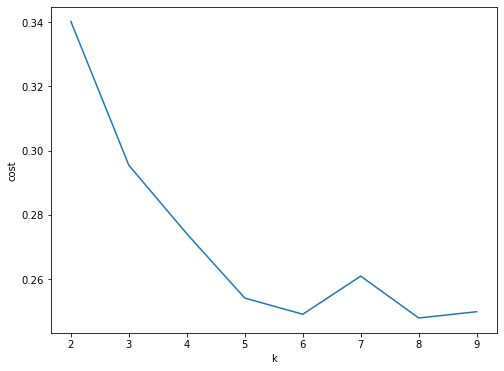

In [15]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("cost")

# Standarize

In [18]:
from pyspark.ml.feature import StandardScaler

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(df)
df_scale=data_scale.transform(df)
df_scale.show(truncate=0)

+---+---+---+---+---+---------------------+----------------------------------------------------------------------------------------------+
|EXT|EST|AGR|CSN|OPN|features             |standardized                                                                                  |
+---+---+---+---+---+---------------------+----------------------------------------------------------------------------------------------+
|4.6|3.6|3.9|3.2|4.5|[4.6,3.6,3.9,3.2,4.5]|[5.0858721468363814,4.17976785406787,5.32573804350229,4.341253632864865,6.966894913544764]    |
|2.0|3.5|4.4|3.7|3.5|[2.0,3.5,4.4,3.7,3.5]|[2.211248759494079,4.063663191454873,6.00852497215643,5.019574513000001,5.41869604386815]     |
|2.5|3.4|4.2|3.4|4.1|[2.5,3.4,4.2,3.4,4.1]|[2.764060949367599,3.9475585288418773,5.7354102006947745,4.612581984918919,6.347615365674118] |
|2.6|3.1|3.8|2.5|3.9|[2.6,3.1,3.8,2.5,3.9]|[2.874623387342303,3.5992445410028884,5.1891806577714625,3.3916044006756763,6.037975591738795]|
|2.9|4.1|4.6|4.8|4.8|[2.9,4

In [20]:
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,10):
    
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    
    KMeans_fit=KMeans_algo.fit(df_scale)
    
    output=KMeans_fit.transform(df_scale)
    
    
    
    score=evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("K = " + str(i).zfill(2) + " --- Silhouette Score: " + str(score))

K = 02 --- Silhouette Score: 0.3078660767323851
K = 03 --- Silhouette Score: 0.2715500072483851
K = 04 --- Silhouette Score: 0.24868107849169274
K = 05 --- Silhouette Score: 0.2692868062099697
K = 06 --- Silhouette Score: 0.253434851454192
K = 07 --- Silhouette Score: 0.24296888732150798
K = 08 --- Silhouette Score: 0.24282405764571416
K = 09 --- Silhouette Score: 0.24271801723878486


Text(0, 0.5, 'cost')

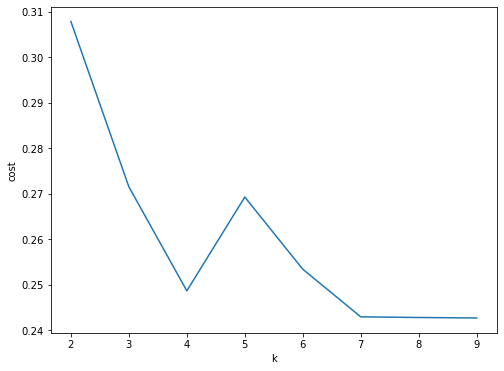

In [21]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("cost")